# Resources

https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/

https://github.com/vwxyzjn/cleanrl?tab=readme-ov-file

In [1]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time
import uuid

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Params

In [2]:
ENV_ARGS = {
    'id': 'BipedalWalker-v3'
}
NUM_ENVS = 3
SEED = 1
LR = 3e-4
NUM_STEPS = 2048
NUM_ITERATIONS = 1000
GAMMA = 0.99
GAE_LAMBDA = 0.95
UPDATE_EPOCHS = 10
CLIP_COEF = 0.2 # the epsilon in KL divergece in PPO paper
ENTROPY_COEF = 0.0
VF_COEF = 0.5
MAX_GRAD_NORM = 0.5
MINI_BATCH_COUNT = 32
UPDATE_PLOTS = 10

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
#output directory
ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output')

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

#seeding
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Make envs

In [3]:
def make_env(gamma, **env_args):
    env = gym.make(**env_args)
    env = gym.wrappers.FlattenObservation(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = gym.wrappers.ClipAction(env)
    # env = gym.wrappers.NormalizeObservation(env)
    # env = gym.wrappers.TransformObservation(env, lambda obs: np.clip(obs, -10, 10))
    # env = gym.wrappers.NormalizeReward(env, gamma = gamma)
    # env = gym.wrappers.TransformReward(env, lambda reward: np.clip(reward, -10, 10))
    return env


In [4]:
# Test env
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(gamma= 0.99, **ENV_ARGS) for _ in range(NUM_ENVS)]
) 

#check to make sure this is continous action
assert isinstance(envs.single_action_space, gym.spaces.Box), 'Only continous action is supported'

# Model

In [5]:
def layer_init(layer: nn.Linear, std = np.sqrt(2), bias_const = 0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class Agent(nn.Module):

    def __init__(self, envs: gym.Env, hidden_size: int = 64):

        super().__init__()
        self.state_shape = np.array(envs.single_observation_space.shape).prod()
        self.action_shape = np.prod(envs.single_action_space.shape)

        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(self.state_shape, hidden_size)),
            #NOTE: why use tanh here? 
            nn.Tanh(),
            layer_init(nn.Linear(hidden_size, hidden_size)),
            nn.Tanh(),
            # NOTE: what's the STD do in layer initialization???
            layer_init(layer = nn.Linear(hidden_size, self.action_shape), std = 0.01),
        )

        #shape = (1, state_shape)
        self.actor_logstd = nn.Parameter(torch.zeros(1, self.action_shape))

        self.critic = nn.Sequential(
            layer_init(nn.Linear(self.state_shape, hidden_size)),
            nn.ReLU(),
            layer_init(nn.Linear(hidden_size, hidden_size)),
            nn.ReLU(),
            # NOTE: what's the STD do in layer initialization???
            layer_init(nn.Linear(hidden_size, 1), std = 1.0),
        )
    
    def get_value(self, x):
        return self.critic(x)
    
    def get_action_and_value(self, x, action = None):
        '''
        @params:
            x: torch.tensor observation, shape = (N, observation size)
            action: torch.tensor action
        @returns:
            action: torch.tensor, shape = (N, action size)
            log_prob: torch.tensor, shape = (N,)
            entropy: torch.tensor, shape = (N,)
            value: torch.tensor, shape = (N,)
        '''
        action_mean = self.actor_mean(x)
        #make action logstd the shape[0] with mean
        action_logstd = self.actor_logstd.expand_as(action_mean)
        #exponential trick to remove log
        action_std = torch.exp(action_logstd)

        probs = torch.distributions.Normal(action_mean, action_std)

        if action is None:
            action = probs.sample() 
        
        #get value from critic
        value = self.get_value(x)
        log_prob = probs.log_prob(action).sum(1)
        #entropy for regularization
        entropy = probs.entropy().sum(1)
        
        return action, log_prob, entropy, value

In [6]:
#Test agent
test_agent = Agent(envs)

sample_state = torch.rand(3, 24)

action, log_prob, entropy, value = test_agent.get_action_and_value(sample_state)

print('action shape = ', action.shape)
print('log prob shape = ', log_prob.shape)
print('entropy shape = ', entropy.shape)
print('value shape = ', value.shape)

del test_agent
del envs

action shape =  torch.Size([3, 4])
log prob shape =  torch.Size([3])
entropy shape =  torch.Size([3])
value shape =  torch.Size([3, 1])


# Utils

In [7]:
def plot(history, show = False, save_path = None):
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()
        
    plt.clf()
    plt.close()

In [8]:
def evaluate(agent, episodes = 10):
    envs = gym.vector.SyncVectorEnv([lambda: make_env(gamma = GAMMA, **ENV_ARGS)])
    agent.eval()
    total_rewards = []
    next_obs, _ = envs.reset()

    while len(total_rewards) < episodes: 
        next_obs = torch.Tensor(next_obs)
        with torch.no_grad():
            action, log_prob, _, value = agent.get_action_and_value(next_obs)

        next_obs, reward, terminated, truncated, info = envs.step(action.numpy())

        if 'final_info' in info:
            for data in info['final_info']:
                if data:
                    reward = data['episode']['r'][0]
                    total_rewards.append(reward)

    return total_rewards

# Training loop

In [9]:
# Create env
envs = gym.vector.AsyncVectorEnv(
    [lambda : make_env(gamma= 0.99, **ENV_ARGS) for _ in range(NUM_ENVS)]
) 
#check to make sure this is continous action
assert isinstance(envs.single_action_space, gym.spaces.Box), 'Only continous action is supported'

agent = Agent(envs)
optimizer = torch.optim.Adam(agent.parameters(), lr = LR, eps = 1e-5)

M = NUM_STEPS
N = NUM_ENVS

label = str(uuid.uuid4()).split('-')[0]
print('run id = ', label)

SAVE_PATH = os.path.join(OUTPUT, label)
FIG_SAVE_PATH = os.path.join(SAVE_PATH, 'plot.png')
if os.path.exists(SAVE_PATH) == False:
    print(f'output folder: {SAVE_PATH}')
    os.makedirs(SAVE_PATH)

obs = torch.zeros((M, N) + envs.single_observation_space.shape)
actions = torch.zeros((M,N) + envs.single_action_space.shape)
log_probs = torch.zeros((M,N))
rewards = torch.zeros((M,N))
dones = torch.zeros((M,N)) # for masking
values = torch.zeros((M,N))

global_step = 0

next_obs, _ = envs.reset()
next_obs = torch.Tensor(next_obs)
next_done = torch.zeros(N) #N is num envs

print('next obs = ', next_obs.shape)
print('next done = ', next_done.shape)

reward_window = deque(maxlen = 100)
history = defaultdict(list)

loop = tqdm(range(NUM_ITERATIONS))
agent.train()

best_score = -float('inf')
evaluation = 0
loss = float('inf')

for iter in loop:

    #ROLLOUT phase
    #M is max steps
    if iter % UPDATE_PLOTS == 0:
        plot(history, save_path=FIG_SAVE_PATH)

    for step in range(M):
        global_step += N

        obs[step] = next_obs
        dones[step] = next_done

        #get action
        #NOTE: no_grad disables gradient calculation --> reduce memory consumption
        #the result of every computation will have requires_grad=False
        with torch.no_grad():
            action, log_prob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()

        actions[step] = action
        log_probs[step] = log_prob

        #make next step with actions
        next_obs, reward, terminated, truncated, info = envs.step(action.numpy())

        next_done = np.logical_or(terminated, truncated)

        #NOTE: difference between view and reshape
        # https://stackoverflow.com/questions/49643225/whats-the-difference-between-reshape-and-view-in-pytorch
        rewards[step] = torch.tensor(reward).view(-1)
        next_obs = torch.tensor(next_obs)
        next_done = torch.tensor(next_done)

        #NOTE: vector envs will automatically reset, so no need to break 
        if 'final_info' in info:
            for data in info['final_info']:
                if data:
                    reward = data['episode']['r']
                    reward_window.append(reward)
                    avg_reward = np.mean(reward_window)
                    history['reward'].append(avg_reward)
                    loop.set_description(f"reward = {avg_reward:.2f}, global_step = {global_step}, best_score = {best_score:.2f}, loss={loss:.2f}")

                    if best_score < avg_reward:
                        best_score = avg_reward
                        #save model
                        torch.save(agent, os.path.join(SAVE_PATH, 'ppo.checkpoint.torch'))

        
    #update the history for plotting, and printing progress

    #OPTIMIZE phase:
    with torch.no_grad():
        #bootstrap values, compute returns
        next_value = agent.get_value(next_obs).reshape(1,-1)
        advantages = torch.zeros_like(rewards)
        last_gae_lambda = 0

        for t in reversed(range(NUM_STEPS)):
            if t == NUM_STEPS - 1:
                next_none_terminal = np.logical_not(next_done)
                next_values = next_value
            else:
                next_none_terminal = np.logical_not(dones[t + 1])
                next_values = values[t + 1]
            
            #A(s,a) = Q(s,a) - V(s,a) = r(t) + gamma * V(s', a) * mask - V(s)
            delta = rewards[t] + GAMMA * next_values * next_none_terminal - values[t]
            #NOTE: learn about this formula
            advantages[t] = last_gae_lambda = delta + GAMMA * GAE_LAMBDA * next_none_terminal * last_gae_lambda
        returns = advantages + values
    
    #flatten the batch
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_log_probs = log_probs.reshape(-1)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    #NOTE: randomize the batch to break correlation
    batch_size = M * N
    mini_batch_size = batch_size // MINI_BATCH_COUNT
    b_indicies = np.arange(batch_size)
    clip_fracs = []
    
    for epoch in range(UPDATE_EPOCHS):
        np.random.shuffle(b_indicies)

        #NOTE: mini-batch update: 
        # pros: reduce memory usage, faster updates
        # pros: a whole batch may stuck in local minima, mini batches introduce randomness
        # cons: estimate a true gradient, larger mini batch size --> more accurate but more memory
        for start in range(0, batch_size, mini_batch_size):
            end = start + mini_batch_size
            mini_indicies = b_indicies[start:end]

            _, new_log_prob, entropy, new_value = agent.get_action_and_value(b_obs[mini_indicies], b_actions[mini_indicies])

            #NOTE: what formula is this? 
            log_ratio = new_log_prob - b_log_probs[mini_indicies]

            ratio = log_ratio.exp() # trick to remove log

            #compute approximate KL: http://joschu.net/blog/kl-approx.html
            with torch.no_grad():
                old_approx_kd = (-log_ratio).mean()
                approximate_kl = ((ratio - 1) - log_ratio).mean()
                clip_fracs += [((ratio - 1.0).abs() > CLIP_COEF).float().mean().item()]

            mb_advantages = b_advantages[mini_indicies]

            #normalize advantage
            mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            #policy loss (actor)

            pg_loss1 = -mb_advantages * ratio
            pg_loss2= -mb_advantages * torch.clamp(ratio, 1 - CLIP_COEF, 1 + CLIP_COEF)

            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            new_value = new_value.view(-1)

            #value loss (MSE)
            v_loss = 0.5 * ((new_value - b_returns[mini_indicies]) ** 2).mean()

            entropy_loss = entropy.mean()

            loss = pg_loss - ENTROPY_COEF * entropy_loss + v_loss * VF_COEF

            optimizer.zero_grad()
            loss.backward()
            #clip grad
            nn.utils.clip_grad_norm_(agent.parameters(), MAX_GRAD_NORM)
            optimizer.step()
    
evaluation = np.mean(evaluate(agent))
print('evaluation = ', np.mean(evaluation))
torch.save(agent, os.path.join(SAVE_PATH, 'ppo.final.torch'))


run id =  f6247724
output folder: /Volumes/SanDisk/NLP_RNN/Reinforcement Learning/policy_gradient/ppo/output/f6247724
next obs =  torch.Size([3, 24])
next done =  torch.Size([3])


reward = -72.94, global_step = 195420, best_score = -73.85, loss=0.03:   3%|▎         | 31/1000 [01:01<32:09,  1.99s/it]  


KeyboardInterrupt: 

# Evaluation

In [17]:
def evaluate(model_path, device = DEVICE, episodes = 10):

    agent = torch.load(model_path)

    envs = gym.vector.SyncVectorEnv([lambda: make_env(gamma = GAMMA, **ENV_ARGS)])
    agent.eval()
    total_rewards = []
    next_obs, _ = envs.reset()

    while len(total_rewards) < episodes: 
        next_obs = torch.Tensor(next_obs).to(device)
        with torch.no_grad():
            action, log_prob, _, value = agent.get_action_and_value(next_obs)

        next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())

        if 'final_info' in info:
            for data in info['final_info']:
                if data:
                    reward = data['episode']['r'][0]
                    print('reward = ', reward)
                    total_rewards.append(reward)
    
    sns.lineplot(y = total_rewards, x = list(range(len(total_rewards))))
    plt.show()
    return total_rewards

reward =  304.9811
reward =  305.7645
reward =  304.9129
reward =  303.95224
reward =  302.35867
reward =  307.29074
reward =  303.80063
reward =  303.12814
reward =  305.00543
reward =  305.16318


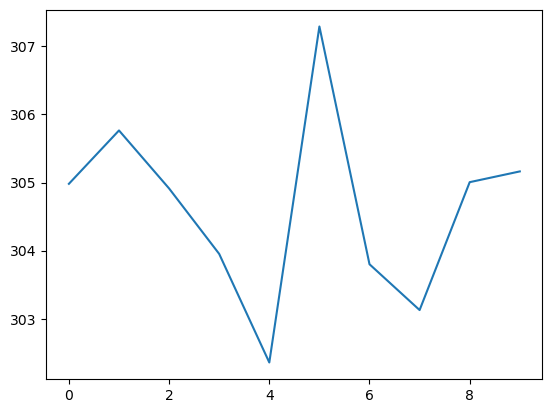

[304.9811,
 305.7645,
 304.9129,
 303.95224,
 302.35867,
 307.29074,
 303.80063,
 303.12814,
 305.00543,
 305.16318]

In [18]:
model_path = os.path.join(OUTPUT, 'good_result', 'ppo.checkpoint.torch')

evaluate(model_path)

In [ ]:
next_obs, _ = envs.reset()
total_rewards = []
episodes = 10

while len(total_rewards) < episodes: 
    next_obs = torch.Tensor(next_obs)
    with torch.no_grad():
        action, log_prob, _, value = agent.get_action_and_value(next_obs)

    next_obs, reward, terminated, truncated, info = envs.step(action.numpy())

    if 'final_info' in info:
        for data in info['final_info']:
            if data:
                reward = data['episode']['r'][0]
                print(reward)
                total_rewards.append(reward)


268.0151
266.8834
260.6238
75.81549
267.05634
263.5786
266.1446
258.57123
263.439
-70.78032


In [ ]:
ENV_ARGS['render_mode'] = 'human'
envs1 = gym.vector.AsyncVectorEnv(
    [lambda : make_env(gamma= 0.99, **ENV_ARGS) for _ in range(NUM_ENVS)]
) 

next_obs, _ = envs1.reset()
total_rewards = []
episodes = 10

while len(total_rewards) < episodes: 
    next_obs = torch.Tensor(next_obs)
    with torch.no_grad():
        action, log_prob, _, value = agent.get_action_and_value(next_obs)

    next_obs, reward, terminated, truncated, info = envs1.step(action.numpy())

    if 'final_info' in info:
        for data in info['final_info']:
            if data:
                reward = data['episode']['r'][0]
                print(reward)
                total_rewards.append(reward)
    
del ENV_ARGS['render_mode']
envs1.close()

Exception ignored in: <function AsyncVectorEnv.__del__ at 0x132e0e310>
Traceback (most recent call last):
  File "/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/vector/async_vector_env.py", line 546, in __del__
    self.close(terminate=True)
  File "/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/vector/vector_env.py", line 265, in close
    self.close_extras(**kwargs)
  File "/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/vector/async_vector_env.py", line 461, in close_extras
    function(timeout)
  File "/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/vector/async_vector_env.py", line 321, in step_wait
    obs, rew, terminated, truncated, info = result
TypeError: cannot unpack non-iterable NoneType object
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated al

25.542747
307.70154
304.33347
-23.915497
305.6151
304.5836
302.65884
303.71445
305.96878
303.6156


# Optuna optimization